<a href="https://colab.research.google.com/github/meiruv/NIPS-Papers-Analysis/blob/main/Nips_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Taking a go on this dataset:
https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated/tasks?taskId=2960

The task here is to model the topic of each NIPS paper using LDA and evaluate the results independently. I will try modelling with LDA and with BERT as proposed here: https://github.com/MaartenGr/BERTopic

I will need to check if I the abstracts are enough for the modelling or if the full text should be used.
I will want to check if the author's name can somehow be used for validation (if I know an author is an expert of one field and the paper is classified under another topic I might suspect the classification is wrong)

In [ ]:
! python -m spacy download en_core_web_lg


# Fetching the Data From Kaggle

In [1]:
! pip install -q kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d rowhitswami/nips-papers-1987-2019-updated

 97% 103M/106M [00:03<00:00, 24.9MB/s] 
100% 106M/106M [00:03<00:00, 29.9MB/s]


In [4]:
import os
import zipfile

local_zip = 'nips-papers-1987-2019-updated.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('nips_papers')
zip_ref.close()

In [5]:
!ls nips_papers

authors.csv  papers.csv


# Exploratory Analysis 

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

## Authors

In [9]:
authors_df = pd.read_csv('nips_papers/authors.csv')
print('Authors df Shape : ',authors_df.shape)
authors_df.head()

Authors df Shape :  (30237, 4)


,source_id,first_name,last_name,institution
0,27,Alan,Murray,NaN
1,27,Anthony,Smith,NaN
2,27,Zoe,Butler,NaN
3,63,Yaser,Abu-Mostafa,NaN
4,60,Michael,Fleisher,NaN


In [13]:
len(authors_df['institution'].unique())

2672

In [ ]:
insts_and_pubs = pd.DataFrame(authors_df['institution'].value_counts()).reset_index()
insts_and_pubs.columns = ['institution', 'Publications']
insts_and_pubs.head(60)

Text(0.5, 0, '# Publications Since 1987)')

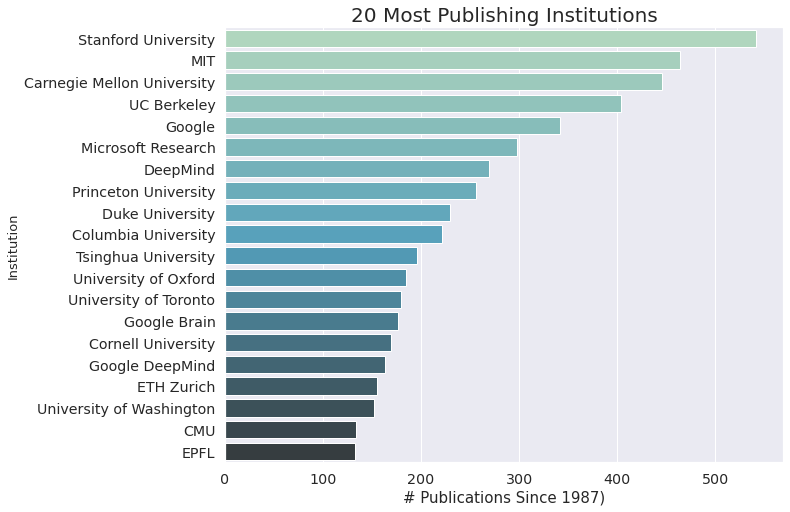

In [25]:
a4_dims = (10, 8)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style = "darkgrid", font_scale=1.3)
ax = sns.barplot(x='Publications', y="institution", data=insts_and_pubs.head(20) , palette = "GnBu_d")
ax.axes.set_title("20 Most Publishing Institutions",fontsize=20)
ax.set_ylabel("Institution",fontsize=13)
ax.set_xlabel("# Publications Since 1987)",fontsize=15)
#ax.set_xticklabels(top_diff_30['Country'],rotation = 45, ha="right")

# fig.savefig('Biggeat_Leap_Sine_2000_Horizontal.jpg')

I found it interesting to look at how many papers each institution published and compare all institutions to find top publishers. This list is limited though because some institutiona and spelled differently-for example MIT appears sometimes as MIT and sometimes as Massachusetts Institute of Technology - row 23, if we combine the amounts on those rows we get more than Stanford which means MIT is the world's leading institution in terms of publications since 1987. Another example is Google having several rows - one for brain, one for deepminds, etc. If we combine those rows it will probably be ranked higher in this table.
Also - fun fact and a bit of pride for Israelis - the Technion is 31st in this list, which reminds us yet again that while such rankings can be calculated by absolute numbers it is more accurate to normalize them based on the institution's size and perhaps bring into the equation its amounts of funding.

It would be interesting to see how many institutions got into this list from each country/continent as well as how many of them are GAMFA and corporates in general. I didn't find an easy way for calculating this so I skipped this idea for the time being.

In [ ]:
# Writers per Paper distribution

writers_per_paper_df = pd.DataFrame(authors_df['source_id'].value_counts()).reset_index()
writers_per_paper_df.columns = ['source_id','n_writers']
writers_per_paper_df.head(60)

In [48]:
writers_per_paper_df[writers_per_paper_df['n_writers']>=10].shape[0] - 80

948

In [44]:
writers_per_paper_df.shape

(4522, 2)

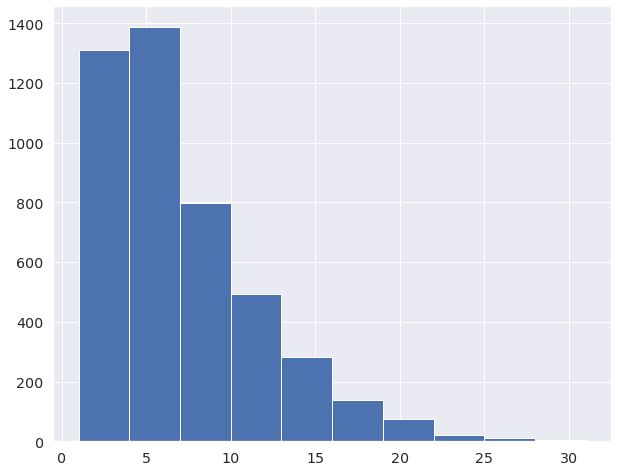

In [43]:
writers_per_paper_df['n_writers'].hist(figsize = (10,8));

There are 4522 papers in this dataset, out of which 80 had 20 authors or more. 
948 has between 10-20 authors and the rest (3494) had less than 10 authors.



In [49]:
4522 - 80 - 948

3494

In [51]:
# Papers per author distribution
authors_df['author'] = authors_df['first_name']+' ' + authors_df['last_name']

In [65]:
papers_per_author_df = pd.DataFrame(authors_df['author'].value_counts()).reset_index()
papers_per_author_df.columns = ['author','n_publications']
papers_per_author_df.head()

,author,n_publications
0,Michael Jordan,111
1,Yoshua Bengio,74
2,Bernhard Schölkopf,69
3,Geoffrey Hinton,63
4,Francis Bach,59


My conclusion from this is to name my child Michael Jordan

In [68]:
# special request from a friend
papers_per_author_df[papers_per_author_df['author']=='Beatrice Golomb']



,author,n_publications
13306,Beatrice Golomb,1


In [67]:
# Another way to query this, I find it useful to keep such snippets
papers_per_author_df.loc[papers_per_author_df['author'].str.startswith('Bea', na=False)]

,author,n_publications
6414,Beat Buesser,1
7326,Beat Pfister,1
7980,Beata Jarosiewicz,1
11416,Beat Flepp,1
13306,Beatrice Golomb,1


### Are there communities here?

Draw a graph from this data. the most basic way will be to draw an edge between each authors that published together and weight the edges based on the amount of publications they have together, then run community detection algorithm and see if there are any. also see top publishers and perhaps place the authors on a map based on their institution to see where those communities occur.

## Papers

In [69]:
papers_df = pd.read_csv('nips_papers/papers.csv')
papers_df.head()

,source_id,year,title,abstract,full_text
0,27,1987,Bit-Serial Neural Networks,NaN,573 \n\nBIT - SERIAL NEURAL NETWORKS \n\nAlan...
1,63,1987,Connectivity Versus Entropy,NaN,1 \n\nCONNECTIVITY VERSUS ENTROPY \n\nYaser S...
2,60,1987,The Hopfield Model with Multi-Level Neurons,NaN,278 \n\nTHE HOPFIELD MODEL WITH MUL TI-LEVEL N...
3,59,1987,How Neural Nets Work,NaN,442 \n\nAlan Lapedes \nRobert Farber \n\nThe...
4,69,1987,Spatial Organization of Neural Networks: A Pro...,NaN,740 \n\nSPATIAL ORGANIZATION OF NEURAL NEn...


In [72]:
# papers per year bar plot
papers_per_year_df = pd.DataFrame(papers_df['year'].value_counts()).reset_index()
papers_per_year_df.columns = ['year','count']

papers_per_year_df.head()

,year,count
0,2019,1428
1,2018,1009
2,2017,679
3,2016,569
4,2014,411


In [75]:
papers_per_year_df_sorted = papers_per_year_df.sort_values(by = 'year',ascending=True)

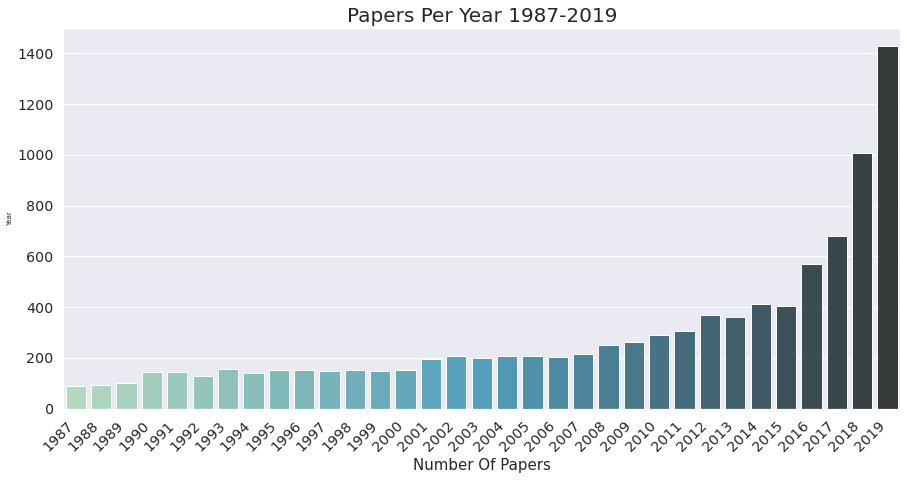

In [81]:
a4_dims = (15, 7)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style = "darkgrid", font_scale=1.3)
ax = sns.barplot(x="year", y="count", data = papers_per_year_df_sorted , palette = "GnBu_d")
ax.axes.set_title("Papers Per Year 1987-2019",fontsize=20)
ax.set_ylabel("Year",fontsize=7)
ax.set_xlabel("Number Of Papers",fontsize=15)
ax.set_xticklabels(papers_per_year_df_sorted['year'],rotation = 45, ha="right");


*   tf - idf on the titles and then sum per year/ decade/ half-decades
*   same on abstracts
*   same on papers.
*   keywors extraction and comparison between years, looking for timely trends, etc.

In [ ]:
papers_df['title'].head(60)

In [83]:
papers_df['full_text'][0]

'573 \n\nBIT - SERIAL NEURAL  NETWORKS \n\nAlan F.  Murray,  Anthony V . W.  Smith  and Zoe F.  Butler. \n\nDepartment of Electrical Engineering,  University of Edinburgh, \n\nThe King\'s Buildings, Mayfield Road,  Edinburgh, \n\nScotland,  EH93JL. \n\nABSTRACT \n\nA  bit  - serial  VLSI  neural  network  is  described  from  an  initial  architecture  for  a \nsynapse array through to silicon layout and board design.  The issues surrounding bit \n- serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel \ndevelopment  of  a  hybrid  analog/digital  neural  network  is  outlined.  Learning  and \nrecall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected \nspecification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 MHz.  This tech(cid:173)\nnique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms, \nusing  a  "paging"  technique  to  time  - multiplex  calculations

     |████████████████████████████████| 827.9 MB 46.1 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=1aba808ba1c732d5e9935a84cd0bb38727e066da35c5e400d1a9086578743eb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-rhg2ed6t/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [123]:
# Checking if I can fetch the institution's location using Spacy

import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

gpe = [] # countries, cities, states
loc = [] # non gpe locations, mountain ranges, bodies of water

city1 = []
country1 = []

for i in range(10):
  gpe = []
  doc = nlp(papers_df['full_text'][i])
  for ent in doc.ents:
      if (ent.label_ == 'GPE'):
          gpe.append(ent.text)
  print('---------- Iteration Number ',i)
  print(gpe)
  city1.append(gpe[0])
  country1.append(gpe[1])





---------- Iteration Number  0
['Edinburgh', 'Scotland', 'VLSI', 'Synapse \n\nStates', 'Tjj', 'UK', 'USA', 'Denver', 'Denver', 'San Diego', 'Sys(cid:173', 'Denver', 'Denver']
---------- Iteration Number  1
['California', 'Pasadena', 'L Pr(nl', 'VI']
---------- Iteration Number  2
['Israel', 'Ik-I(C', 'Xk', 'Hopfleld', 'sively', 'i.i.', 'netwock', 'Israel']
---------- Iteration Number  3
['Los  Alamos', 'z(t -\n', 'T"\'i', 'J.Sidorowich', 'Physica', 'Takens', 'Cambridge', 'MA', 'Univ']
---------- Iteration Number  4
['Athens', 'Zographos', 'Athens', 'Greece', 'rea(cid:173', 'il(cid:173', 'Pr~(kM', 'Istanbul', 'Turkey', 'N.Y.', 'Scient', 'Amer.']
---------- Iteration Number  5
['U.S.', 'igned', 'neu(cid:173', 'Yij', 'neu(cid:173', 'Englewood', 'New  Jersey', 'Soc']
---------- Iteration Number  6
['Los Angeles', 'Barto', 'Barto', 'Barto, et al.', 'Stanislaus', 'Turlock', 'California', 'Barto', 'ADALINE', 'algorithmS.', 'Holland', 'Barto', 'Chambersl', 'Barto', 'Sutton', 'Barto', 'Edinburg

In [125]:
i = 7
papers_df['full_text'][i]

'554 \n\nSTABILITY RESULTS  FOR NEURAL  NETWORKS \n\nA.  N.  Michell, J. A.  FarreUi  , and W.  Porod2 \n\nDepartment of Electrical and  Computer Engineering \n\nUniversity of Notre  Dame \n\nNotre Dame, IN 46556 \n\nABSTRACT \n\nIn the present paper we survey and utilize results from the qualitative theory of large \nscale interconnected dynamical systems in order to develop  a  qualitative theory for  the \nHopfield model of neural networks.  In our approach we  view such networks as  an inter(cid:173)\nconnection of many single neurons.  Our results  are  phrased in  terms of the  qualitative \nproperties of the individual neurons and in terms of the properties of the interconnecting \nstructure of the neural  networks.  Aspects of neural networks which  we  address include \nasymptotic stability,  exponential stability,  and instability  of an  equilibrium;  estimates \nof trajectory bounds; estimates of the domain of attraction of an asymptotically stable \nequilibrium;  and stabi

In [124]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

gpe = [] # countries, cities, states

city2 = []
country2 = []

for i in range(10):
  gpe = []
  doc = nlp(papers_df['full_text'][i].lower().split('abstract')[0].replace('\n',''))
  for ent in doc.ents:
      if (ent.label_ == 'GPE'):
          gpe.append(ent.text)
  print('---------- Iteration Number ',i)
  print(gpe)





---------- Iteration Number  0
['mayfield road', 'edinburgh', 'scotland']
---------- Iteration Number  1
['california', 'pasadena']
---------- Iteration Number  2
['israel']
---------- Iteration Number  3
[]
---------- Iteration Number  4
['athens', 'athens', 'greece']
---------- Iteration Number  5
[]
---------- Iteration Number  6
['los angeles']
---------- Iteration Number  7
[]
---------- Iteration Number  8
['hampton va']
---------- Iteration Number  9
[]


In [113]:
papers_df['full_text'][i].lower()

'573 \n\nbit - serial neural  networks \n\nalan f.  murray,  anthony v . w.  smith  and zoe f.  butler. \n\ndepartment of electrical engineering,  university of edinburgh, \n\nthe king\'s buildings, mayfield road,  edinburgh, \n\nscotland,  eh93jl. \n\nabstract \n\na  bit  - serial  vlsi  neural  network  is  described  from  an  initial  architecture  for  a \nsynapse array through to silicon layout and board design.  the issues surrounding bit \n- serial  computation,  and  analog/digital  arithmetic  are  discussed  and  the  parallel \ndevelopment  of  a  hybrid  analog/digital  neural  network  is  outlined.  learning  and \nrecall  capabilities  are  reported  for  the  bit  - serial  network  along  with  a  projected \nspecification  for  a  64  - neuron,  bit  - serial  board  operating  at 20 mhz.  this tech(cid:173)\nnique  is  extended  to  a  256  (2562  synapses)  network  with  an  update  time  of 3ms, \nusing  a  "paging"  technique  to  time  - multiplex  calculations

In [120]:
i = 3
papers_df['full_text'][i].lower().split('abstract')[0].replace('\n','')

'442 alan  lapedes robert  farber theoretical division how  neural  nets  work los  alamos  national laboratory los  alamos,  nm  87545 '

In [121]:
papers_df['full_text'][i].lower().split('abstract')[0]

'442 \n\nalan  lapedes \nrobert  farber \n\ntheoretical division \n\nhow  neural  nets  work \n\nlos  alamos  national laboratory \n\nlos  alamos,  nm  87545 \n\n'

In [122]:
papers_df['full_text'][i]

'442 \n\nAlan  Lapedes \nRobert  Farber \n\nTheoretical Division \n\nHow  Neural  Nets  Work \n\nLos  Alamos  National Laboratory \n\nLos  Alamos,  NM  87545 \n\nAbstract: \n\nThere is  presently great interest in the abilities of neural networks to mimic \n"qualitative reasoning"  by manipulating neural incodings of symbols.  Less work \nhas  been performed on using neural networks to process floating  point numbers \nand it is  sometimes stated that neural networks are somehow inherently inaccu(cid:173)\nrate  and  therefore  best  suited  for  "fuzzy"  qualitative reasoning.  Nevertheless, \nthe  potential  speed  of massively  parallel  operations  make  neural  net  "number \ncrunching"  an interesting topic  to explore.  In this paper we  discuss some of our \nwork in which we  demonstrate that for  certain applications neural networks can \nachieve  significantly  higher  numerical  accuracy  than  more  conventional  tech(cid:173)\nniques.  In  particular,  prediction  of futur